# DCA Optimization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Simulation parameters
initial_val = 100

### Data 

Historical OHLCVT (Open, High, Low, Close, Volume, Trades) data for trading pairs were downloaded from [Kraken](https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data). This source includes all traded pairs on Kraken for 1, 5, 15, 60, 720, and 1440 minute intervals. We will be utilizing the ETH-DAI pair. 

In [3]:
def read_bars(path):
    """
    OHLCVT bars downloaded from Kraken. 
    Unsure on the exact time format...
    """
    names = ["Time", "Open", "High", "Low", "Close", "Volume", "Trades"]
    df = pd.read_csv(path, names=names)
    df["Time"] = pd.to_datetime(df["Time"], unit="s")
    df.drop(["Trades"], axis=1, inplace=True)
    return df

In [4]:
df_1m = read_bars("data/ETH_OHLCVT/ETHDAI_1.csv")    # 1 minute intervals
df_1h = read_bars("data/ETH_OHLCVT/ETHDAI_60.csv")   # 1 hour (60 minute) intervals
df_1d = read_bars("data/ETH_OHLCVT/ETHDAI_1440.csv") # 1 day (1440 minute) intervals 

### Uniform Dollar Cost Averaging

Aimed to be the simplest solution. Here we transact at the same time interval and same initial asset size. This results in a constant rate of depletion of initial asset. Amount of target asset attained through this depletion depends on market prices. 

In [5]:
class uniformDCABacktest:
    
    def __init__(self, df, initial_val, time_of_bar="Close"):
        """
        Provide data and simulation parameters
        
        Parameters
        ----------
        df : pd.DataFrame
            OHLC bars of initial_asset priced in target_asset
            
        initial_val : float
            Initial amount of initial_asset held
            
        time_of_bar : str from ["Open", "High", "Low", "Close"]
            Time of bar to use for price quotes
        """
        
        # Inputs
        self.df = df
        self.initial_val = initial_val
        self.time_of_bar = time_of_bar
        
        # Amount of initial_asset to sell each transaction
        # Currently uses length of df to find uniform amount
        # Can be changed to use n_periods or some target end date
        self.val = initial_val / len(df)
        
        # Initialize backtest data structures
        self.initial_asset_balance = [self.initial_val]
        self.target_asset_balance = [0.0]
        
    def sell(self, price):
        self.initial_asset_balance.append(self.initial_asset_balance[-1] - self.val)
        self.target_asset_balance.append(self.target_asset_balance[-1] + self.val*price)
        
    def run(self):
        """
        Run backtest, populate backtest data structures
        """
        
        # Iterate over OHCLV bars of data
        # Fully automated trading systems need some API 
        # that pushes these OHCLV bars in real time
        for i in range(1, len(self.df)):
            price = self.df.iloc[i][self.time_of_bar]
            self.sell(price)

In [6]:
backtest_1m = uniformDCABacktest(df_1m, initial_val)
backtest_1h = uniformDCABacktest(df_1h, initial_val)
backtest_1d = uniformDCABacktest(df_1d, initial_val)

In [7]:
backtest_1m.run()
backtest_1h.run()
backtest_1d.run()

In [8]:
def plot_backtests(backtests, backtest_labels, 
                   initial_asset="ETH", target_asset="DAI", 
                   title="Uniform DCA Performance", fontsize="large"):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    ax[1].set_xlabel("Date", fontsize=fontsize)
    
    for i, b in enumerate(backtests):
        ax[0].step(b.df["Time"].values, b.initial_asset_balance, label=backtest_labels[i])
        ax[1].step(b.df["Time"].values, b.target_asset_balance, label=backtest_labels[i])
        
    ax[0].legend(fontsize=fontsize, loc="upper right")
    ax[0].set_ylabel("${} Balance".format(initial_asset))
    ax[1].legend(fontsize=fontsize, loc="lower right")
    ax[1].set_ylabel("${} Balance".format(target_asset))
    ax[0].set_title(title, fontsize=fontsize)

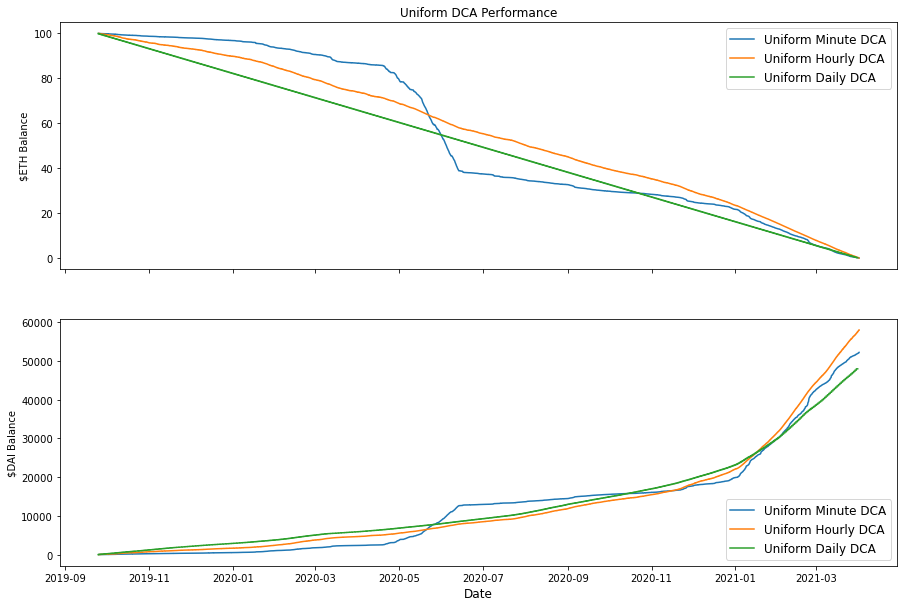

In [9]:
plot_backtests([backtest_1m, backtest_1h, backtest_1d], 
               ["Uniform Minute DCA", "Uniform Hourly DCA", "Uniform Daily DCA"])

###  What is a 'good' and how can we do 'better'?

Dollar cost averaging is typically deployed by investors who want to reduce the impact of volatility on their purchase price. 

We are particularly interested in avoiding when the target asset is expensive in terms of the initial asset. 

This leads to two potential DCA augmentations:
- What if we sat out (refrained from transacting) during the worst times?
- What if we used some indicator (ATR, BBands, RSI, etc.) to smoothly adjust our transaction times?

### Idea 1: Sit out during the worst times

### Idea 2: Smoothly adjust within ranges

This idea will utilize some sort of indicator (like average true range, bollinger bands, RSI, etc.) to sell some amount in the range [minSellAmount, maxSellAmount]. 